In [2]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
from numpy.linalg import matrix_power                  # This is to raise matrices to powers
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
import sympy as sp

# 5.1

In [32]:
sys.path.append('../External_Functions')                       # Add the folder with the functions to the path
from MyFunctions import *
matplotlib_plotparameters()                                    # Set the plot parameters to something nice
from ExternalFunctions import Chi2Regression, nice_string_output, add_text_to_ax

In [33]:
data = np.genfromtxt('data_GlacierSizes.txt', delimiter=',', skip_header=1)    # Load the data

In [34]:
A=data[:,0]
A_sigma=data[:,1]
V = data[:,2]
V_sigma = data[:,3]

Mean relative uncertainty of A:  0.013281048830950434
Mean relative uncertainty of V:  0.10065155981461331


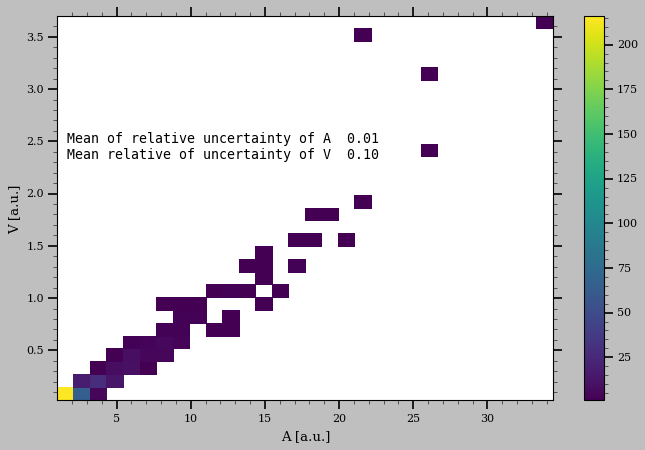

In [39]:
rel_unc_A = A_sigma/A
rel_unc_V = V_sigma/V

mean_rel_unc_A = np.mean(rel_unc_A)
mean_rel_unc_V = np.mean(rel_unc_V)

print('Mean relative uncertainty of A: ', mean_rel_unc_A)
print('Mean relative uncertainty of V: ', mean_rel_unc_V)

Nbins=30
A_binwidth, A_range = bins_create(A, Nbins)

V_binwidth, V_range = bins_create(V, Nbins)


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist2d(A, V, bins=Nbins, range=[A_range, V_range], cmap='viridis', cmin=1)

#make colorbar
cbar = fig.colorbar(ax.get_children()[0], ax=ax);

ax.set_xlabel('A [a.u.]')
ax.set_ylabel('V [a.u.]')

d = {'Mean of relative uncertainty of A': mean_rel_unc_A, 'Mean relative of uncertainty of V': mean_rel_unc_V}
txt = nice_string_output(d, extra_spacing=2, decimals=2)
add_text_to_ax(0.02, 0.70, txt, ax, fontsize=12)

fig.savefig('Figures/A_V_hist.png')


In [108]:
Nbins2d=17
x_center_2D, mean_2D, std_2D = profile_x(A, V, bins=(Nbins2d, Nbins2d), xyrange=[A_range, V_range])
x_binwidth_2D = x_center_2D[1] - x_center_2D[0]

mask = std_2D != 0
x_center_2D = x_center_2D[mask]
mean_2D = mean_2D[mask]
std_2D = std_2D[mask]

In [109]:
def fit(x, a, b):
    return a*x**(3/2)+b

def fitosc(x, a, b,c,d):
    return a*x**(3/2)+b+c*np.sin(d*x)

def linear(x, a, b):
    return a*x+b

chi2_linear = Chi2Regression(linear, x_center_2D, mean_2D, std_2D)
linear_V = Minuit(chi2_linear, a=0.5, b=1)
linear_V.migrad()

chi2_fit = Chi2Regression(fit, x_center_2D, mean_2D, std_2D)
fit_V = Minuit(chi2_fit, a=0.5, b=1)
fit_V.migrad()



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.36                      │              Nfcn = 33               │
│ EDM = 1.32e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  21.5e-3  │  0.7e-3   │            │            │         │         │       │
│ 1 │ b    │   0.038   │   0.013   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  5.33e-07 -7.54e-06 │
│ b │ -7.54e-06   0.00018 │
└───┴─────────────────────┘

0.0013479568921251441


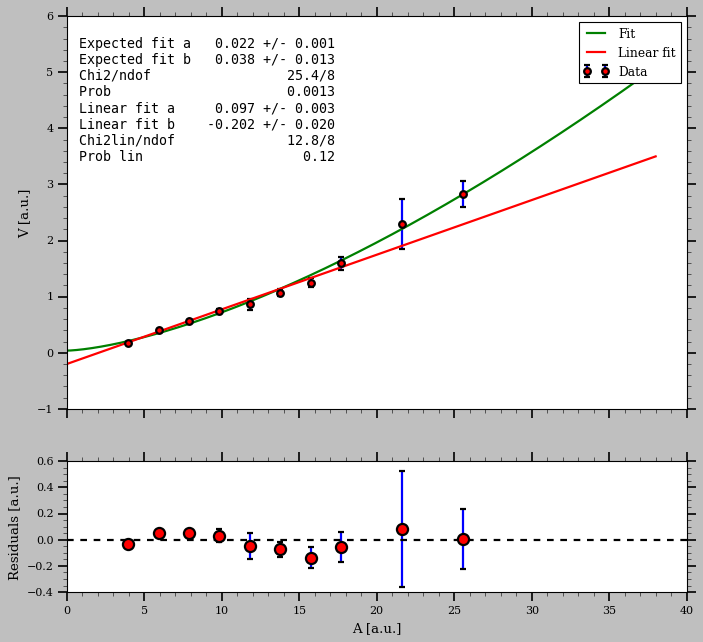

In [111]:
doffit = len(x_center_2D) - 2
chi2_test, ndof= chi2_prob(fit_V, doffit)
print(chi2_test)

chi2_lin,ndof = chi2_prob(linear_V, doffit)

A_space = np.linspace(0, 38, 1000)

fig1, ax1 = plt.subplots(2,1,figsize=(10,9), gridspec_kw={'height_ratios': [3, 1]},sharex=True)

ax1[0].errorbar(x_center_2D, mean_2D, yerr=std_2D, fmt='o', label='Data',markersize=6)
ax1[0].plot(A_space, fit(A_space, *fit_V.values), label='Fit')
ax1[0].plot(A_space, linear(A_space, *linear_V.values), label='Linear fit')

ax1[0].set_ylabel('V [a.u.]')
ax1[0].legend()

d = {'Expected fit a': [fit_V.values['a'], fit_V.errors['a']], 
'Expected fit b': [fit_V.values['b'], fit_V.errors['b']], 
'Chi2/ndof': f"{fit_V.fval:.1f}" '/' f"{doffit:.0f}",
'Prob': f"{chi2_test:.4f}",
'Linear fit a': [linear_V.values['a'], linear_V.errors['a']],
'Linear fit b': [linear_V.values['b'], linear_V.errors['b']],
'Chi2lin/ndof': f"{linear_V.fval:.1f}" '/' f"{doffit:.0f}",
'Prob lin': f"{chi2_lin:.2f}"}

txt1 = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.950, txt1, ax1[0], fontsize=12)

ax1[1].errorbar(x_center_2D, mean_2D-fit(x_center_2D, *fit_V.values), yerr=std_2D, fmt='o', label='Data')
ax1[1].axhline(0, color='k', linestyle='--')
ax1[1].set_ylabel('Residuals [a.u.]')
ax1[1].set_xlabel('A [a.u.]')

fig1.savefig('Figures/A_V_fit.png')